In [1]:
import pickle
import os
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read embedding
data = pickle.loads(
                    open(os.path.join('output', 'embeddings.pickle'), 'rb').read()
                    )

In [3]:
# label encoding
# svc accepts 1D 'y' so we'll not one hot encode
enc = LabelEncoder()
labels = enc.fit_transform(data['labels'])

In [4]:
X = data['embeddings']
y = labels
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3)

### SVM

In [5]:
# fit svm model
model = SVC(C=1.0, kernel='linear', probability=True)
model.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [9]:
target_names = list(set(data['labels']))
len(target_names)
print(target_names)
print(enc.transform(target_names))

['Kishor_Neupane', 'Suravi_Regmi', 'Vladimir_Putin', 'Bipin_Kc']
[1 2 3 0]


In [7]:
t_names = enc.inverse_transform(enc.transform(target_names))
t_names

/home/bean/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


array(['Bipin_Kc', 'Kishor_Neupane', 'Vladimir_Putin', 'Suravi_Regmi'],
      dtype='<U14')

In [8]:
# just sorting names to match the labels for generating reports
a = target_names
b = [i for i in range(len(target_names))]
print(a)
s = sorted(zip(a,b))
a,b = map(list, zip(*s))
tar_names = a
tar_names

['Bipin_Kc', 'Kishor_Neupane', 'Vladimir_Putin', 'Suravi_Regmi']


['Bipin_Kc', 'Kishor_Neupane', 'Suravi_Regmi', 'Vladimir_Putin']

Test accuracy:  0.9166666666666666
[0 1 2 3]
                precision    recall  f1-score   support

      Bipin_Kc       1.00      0.71      0.83         7
Kishor_Neupane       0.80      1.00      0.89         8
  Suravi_Regmi       1.00      1.00      1.00         4
Vladimir_Putin       1.00      1.00      1.00         5

   avg / total       0.93      0.92      0.91        24



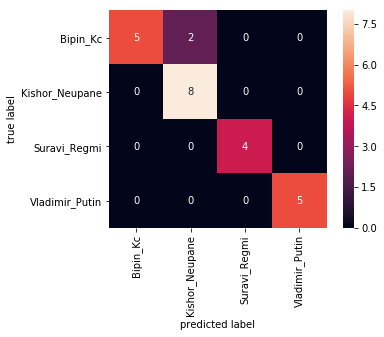

In [9]:
# testing or prediction
y_preds = model.predict(X_test)

#print(enc.inverse_transform(y_test))

accuracy = accuracy_score(y_test, y_preds)
print('Test accuracy: ', accuracy)

print(model.classes_)

clf_report = classification_report(y_test, y_preds, target_names=tar_names)
conf_mat = confusion_matrix(y_test, y_preds)
sns.heatmap(conf_mat, square=True, annot=True, fmt='d', cbar=True,
            xticklabels=tar_names,
            yticklabels=tar_names)
plt.ylabel('true label')
plt.xlabel('predicted label');

print(clf_report)

In [10]:
# save model
with open(os.path.join('output', 'recognition_model_svm.pickle'), 'wb') as f:
    f.write(pickle.dumps(model))

# save label encoder
with open(os.path.join('output', 'label_encoded.pickle'), 'wb') as f:
    f.write(pickle.dumps(enc))

### KNN

In [12]:
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV

# param_grid = {'n_neighbors': [1,2,3,5,8,13]}
clf = neighbors.KNeighborsClassifier(n_neighbors=2, algorithm='ball_tree', weights='distance')
clf = clf.fit(X_train, y_train)

In [13]:
clf.get_params()

{'algorithm': 'ball_tree',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': 1,
 'n_neighbors': 2,
 'p': 2,
 'weights': 'distance'}

Test accuracy:  0.9166666666666666
                precision    recall  f1-score   support

      Bipin_Kc       1.00      0.71      0.83         7
Kishor_Neupane       0.80      1.00      0.89         8
Vladimir_Putin       1.00      1.00      1.00         4
  Suravi_Regmi       1.00      1.00      1.00         5

   avg / total       0.93      0.92      0.91        24



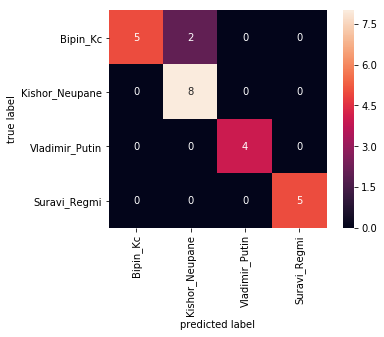

In [14]:
# testing or prediction
y_preds = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_preds)
print('Test accuracy: ', accuracy)


clf_report = classification_report(y_test, y_preds, target_names=target_names)
conf_mat = confusion_matrix(y_test, y_preds)
sns.heatmap(conf_mat, square=True, annot=True, fmt='d', cbar=True,
            xticklabels=target_names,
            yticklabels=target_names)
plt.ylabel('true label')
plt.xlabel('predicted label');

print(clf_report)

In [15]:
# save model
with open(os.path.join('output', 'recognition_model_knn.pickle'), 'wb') as f:
    f.write(pickle.dumps(clf))

### Neural network

In [5]:
train_x = np.asarray(X_train)
train_y = np.asarray(y_train)

test_x = np.asarray(X_test)
test_y = np.asarray(y_test)

In [6]:
# to categorical
# ...
from keras.utils import to_categorical
onehot = to_categorical(train_y)
onehot_test = to_categorical(test_y)

Using TensorFlow backend.


In [7]:
train_x.shape

(56, 128)

In [10]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten

model = Sequential()

# input layer
model.add(Dense(128, input_shape=(128,), activation='relu'))
model.add(Dropout(0.2))

# hidden layers
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

# model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.2))

# output layer
model.add(Dense(len(target_names), activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                4128      
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 132       
Total params: 20,772
Trainable params: 20,772
Non-trainable params: 0
_________________________________________________________________


In [11]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [12]:
results = model.fit(train_x, onehot, epochs=5, validation_split=0.2)

Train on 44 samples, validate on 12 samples
Epoch 1/5
44/44 [==============================] - 1s 30ms/step - loss: 1.3805 - acc: 0.3182 - val_loss: 1.3518 - val_acc: 0.5833
Epoch 2/5
44/44 [==============================] - 0s 238us/step - loss: 1.3532 - acc: 0.4545 - val_loss: 1.3187 - val_acc: 0.5833
Epoch 3/5
44/44 [==============================] - 0s 351us/step - loss: 1.3122 - acc: 0.5000 - val_loss: 1.2846 - val_acc: 0.5833
Epoch 4/5
44/44 [==============================] - 0s 238us/step - loss: 1.2820 - acc: 0.5909 - val_loss: 1.2496 - val_acc: 0.6667
Epoch 5/5
44/44 [==============================] - 0s 187us/step - loss: 1.2366 - acc: 0.6591 - val_loss: 1.2143 - val_acc: 0.7500


In [13]:
np.mean(results.history['val_acc'])

0.6333333253860474

In [14]:
loss, acc = model.evaluate(test_x, onehot_test)
print(acc)

24/24 [==============================] - 0s 142us/step
0.625


In [15]:
# save model
with open(os.path.join('output', 'recognition_model_nn.pickle'), 'wb') as f:
    f.write(pickle.dumps(model))